In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as spectra_utils
import analyze_tools.monte_carlo as atm

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

In [12]:
np.arctan(0)

0.0

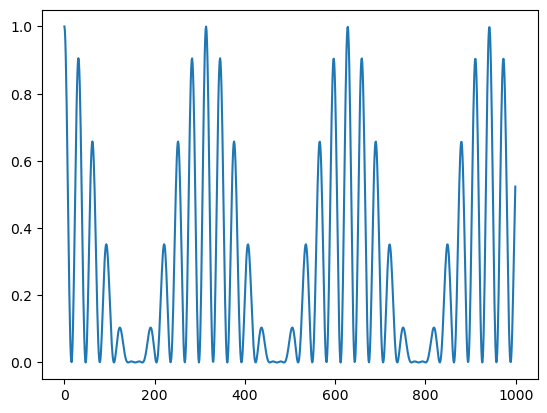

In [8]:
x = np.linspace(0,10,1000)

o1 = 10
o2 = 1

fig, ax = plt.subplots()

ax.plot((np.cos(o1 * x) * np.cos(o2 * x)) ** 2)

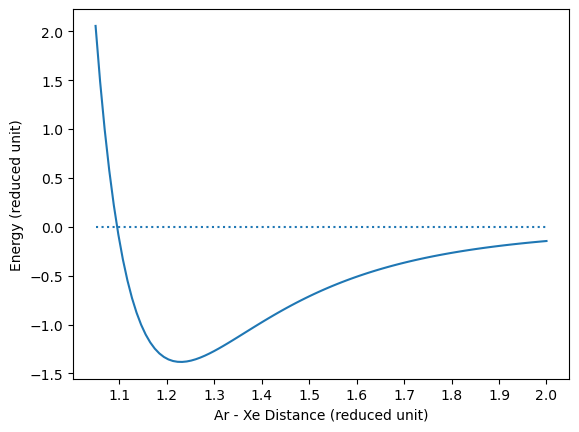

In [10]:
potential_function = lambda r:  4 * red.epsilon_Ar_Xe \
            * ( (red.sigma_Ar_Xe/r)**12 - (red.sigma_Ar_Xe/r)**6 )

fig,ax = plt.subplots()

r = np.linspace(1.05, 2.0, 100)
ax.plot(r, potential_function(r))
ax.hlines(0, min(r), max(r), linestyle = 'dotted')

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xlabel('Ar - Xe Distance (reduced unit)')
ax.set_ylabel('Energy (reduced unit)')

fig.savefig('figure/potential.jpeg',dpi = 600)

#
# DEFINING FUNCTION
## WARNING: NEXT CELL WILL RUN SIMULATIONS
#


Lxy = 3e7; Lz = 3e3
def get_ArXePair(d_arxe, v_ar = 0, h = 0, n_pairs = 1, Lxy=Lxy, Lz=Lz):
    """
    """
    atoms = AtomsInBox(
        Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
        mass_dict = red.mass_dict)

    v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

    for i in range(n_pairs):
        if i == 0:
            r0 = np.zeros(3)
        else:
            r0 = np.hstack(
                [
                    #np.random.uniform(-Lxy/2+10, Lxy/2-10, size = 2), 
                    np.zeros(2),
                    np.random.uniform(-Lz/2+10, Lz/2-10)]
            )
        atoms.add(
                elements = ["Ar"],
                r = np.array([[0.0, h, -d_arxe/2]]) + r0,
                r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
                )
        
        atoms.add(
                elements = ["Xe"],
                r = np.array([[0.0,0.0,d_arxe/2]]) + r0,
                r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
                )
    
    idxAr = atoms.element_idx(element = "Ar")
    idxXe = atoms.element_idx(element = "Xe")
    epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)
    
    # calculator to the atoms object
    atoms.add_calculator(
        calculator_class = Calculator,
        calculator_kwargs = {
            "epsilon": epsilon_mat, "sigma" : sigma_mat, 
            "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
            "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
        })
    
    atoms.update_distance()
    
    return atoms

def get_field(coup_str, amplitude, T = None, mode = False, Lxy = Lxy, Lz = Lz, field = 'cavity'):
    if mode == 'multi':
        k_vector_int = np.array(
            [[i,0,0] for i in range(1,100)]
            ,dtype=np.float64)
    elif isinstance(mode, int):
        k_vector_int = np.array([[mode,0,0]])
    elif isinstance(mode, list):
        k_vector_int = np.array(
            [[i,0,0] for i in mode], 
            dtype = np.float64)
    else:
        raise Exception('Mode have to be either "multi" or an integer!')
    
    if field == 'cavity':
        VectorPotentialClass = CavityVectorPotential
    elif field == 'free':
        VectorPotentialClass = FreeVectorPotential
    
    Afield = VectorPotentialClass(
            k_vector_int = k_vector_int, amplitude = amplitude,
            Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = coup_str, T = T / red.temp
            )

    return Afield

def get_radprofile(rd, windows = 10):
    Afield = rd['field']
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = at.profiling_rad(omega, rad_energy)
    
    sorted_idx = np.argsort(omega_profile)

    if windows == 0:
        omega_profile = np.array(omega_profile)[sorted_idx] 
        final_rad_profile = np.array(final_rad_profile)[sorted_idx]
    else:
        omega_profile, final_rad_profile = moving_average(
            np.array(omega_profile)[sorted_idx], 
            np.array(final_rad_profile)[sorted_idx], windows)

    return omega_profile, final_rad_profile

In [11]:
##################################
#"""
#Single pair of Ar-Xe
#Single mode @ resonance
#Examining the coupling strength
#"""
##################################

single_mode_result_dict = {}

for i, ct in enumerate([1, 10,30]):
    
    atoms = get_ArXePair(1.2, n_pairs = 1)
    
    field = get_field(mode = 23, coup_str = ct * Lxy, amplitude = 'zero', T = 0)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)

    single_mode_result_dict.update({ct: rd})
    

In [4]:
import importlib
spectra_utils = importlib.reload(spectra_utils)

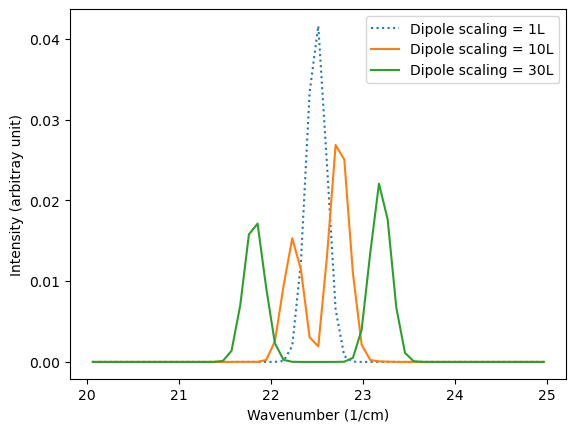

In [5]:
fig,ax = plt.subplots()

for ct, rd in single_mode_result_dict.items():
    
    dipole_spectra = spectra_utils.DipoleSpectra(
        dtps = 1e-2, convert_function = {'time': red.convert_time})
    dipole_spectra.add_result_dict(rd)
    wn, ir = dipole_spectra()

    ir = np.sum(ir, axis = 0)
    ir = ir[(wn < 25) * (wn > 20)]
    wn = wn[(wn < 25) * (wn > 20)]
    
    ax.plot(
        wn, ir, label = "Dipole scaling = {}L".format(ct),
        linestyle = 'dotted' if ct == 1 else None
    )

ax.set_xlabel('Wavenumber (1/cm)')
ax.set_ylabel('Intensity (arbitray unit)')
ax.legend()
fig.savefig('figure/single.jpeg',dpi=600)

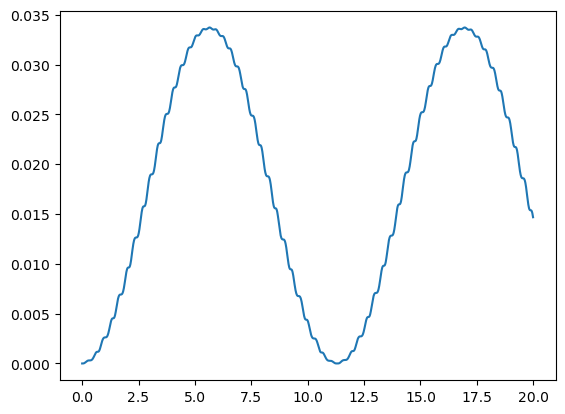

In [23]:
field = single_mode_result_dict[30]['field']

fig,ax = plt.subplots()

ax.plot(
    field.history['t'][:2000], 
    field.history['energy'][:2000]
)


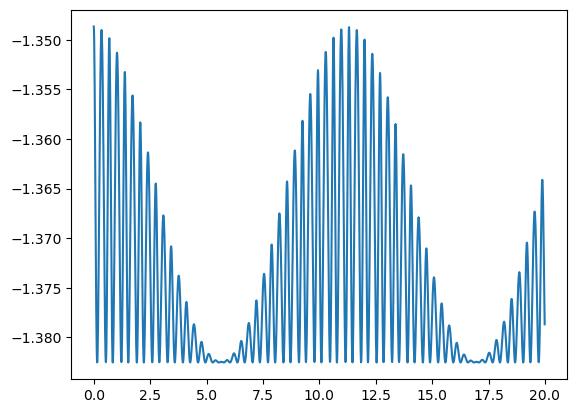

In [19]:
atoms = single_mode_result_dict[30]['atoms']

fig,ax = plt.subplots()

ax.plot(
    atoms.observable['t'][:2000], 
    atoms.observable['potential'][:2000]
)

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the coupling strength
"""

multi_mode_atoms_dict = {}

for i, ct in enumerate([1, 10,30]):
    
    atoms = get_ArXePair(1.2)
    
    field = get_field(mode = 'multi', coup_str = ct)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    multi_mode_atoms_dict.update({ct: atoms})
    

In [ ]:
"""
Single pair of Ar-Xe
Single mode @ resonance
Examining the Ar-Xe initial distance
"""
single_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 23, coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 20000, verbose = False)
    atoms = rd['atoms']

    single_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in single_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000))
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 100) * (wn > 0)]
        wn = wn[(wn < 100) * (wn > 0)]
    else: 
        i = 0
        ir = ir[(wn < 45) * (wn > 18)]
        wn = wn[(wn < 45) * (wn > 18)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/single_distance.jpeg',dpi=600)

In [ ]:
"""
Single pair of Ar-Xe
Multiple mode from 1->100
Examining the Ar-Xe initial distance
"""
multi_mode_datoms_dict = {}

for i, d in enumerate([1.1, 1.15, 1.2, 1.3]):
    
    atoms = get_ArXePair(d)
    
    field = get_field(mode = 'multi', coup_str = 30)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    multi_mode_datoms_dict.update({d: atoms})
    

In [ ]:
fig,ax = plt.subplots(2, figsize = (6,8))

for d, atoms in multi_mode_datoms_dict.items():
    
    wn, ir = dipole_spectra(atoms, h = 1e-2, time_frame = (0,1000), quant = 'dipole_velocity')
    
    if d == 1.4 or d == 1.1: 
        i = 1
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    else: 
        i = 0
        ir = ir[(wn < 30) * (wn > 15)]
        wn = wn[(wn < 30) * (wn > 15)]
    
    ax[i].plot(
        wn, ir, label = "Ar-Xe dist. = {}".format(d)
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
fig.savefig('figure/multi_distance.jpeg',dpi=600)

In [ ]:
"""
Multiple pair of Ar-Xe
Single mode @ resonance
Examining the coupling strength
"""

single_mode_atoms_dict = {}

np.random.seed(100)

for i, ct in enumerate([10, 20, 50]):
    
    atoms = get_ArXePair(1.21, n_pairs = 16)
    
    field = get_field(mode = 23, coup_str = ct)
    
    t, rd = single_collision_simulation(
        0, h = 1e-2, atoms = atoms, field = field, 
        max_steps = 10000, verbose = False)
    atoms = rd['atoms']

    single_mode_atoms_dict.update({ct: atoms})

In [ ]:
fig,ax = plt.subplots(3)

for i, (ct, atoms) in enumerate(single_mode_atoms_dict.items()):
    #if ct == 5:continue
    wn, ir = dipole_spectra(
        atoms, h = 1e-2, time_frame = (50,np.inf),
        quant = 'dipole_velocity', windows = 'BH'
    )
    ir = ir[(wn < 40) * (wn > 10)]
    wn = wn[(wn < 40) * (wn > 10)]
    
    ax[i].plot(
        wn, ir, label = "Dipole scaling = {}L".format(ct),
    )

#ax.set_xlabel('Wavenumber (1/cm)')
#ax.set_ylabel('Intensity (arbitray unit)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.savefig('figure/multicomplex_single.jpeg',dpi=600)

In [ ]:
atoms = single_mode_atoms_dict[5]
dpv = np.array(atoms.observable['dipole_velocity'])

i = 7
single_dpv = dpv[:,2*i,:] + dpv[:,2*i+1,:]
time = atoms.observable['t']

wn, ir = fft_autocorr(time, single_dpv, 1e-2, windows = 'BH')

fig,ax = plt.subplots()

ax.plot(wn,ir)
ax.set_xlim(10,30)